In this post, I will work on replicating the momentum decile portfolios. Momentum refers to tendency that rising stocks tend to rise, while falling stocks are likely to fall. To be specific, It involves going long stocks, futures or market ETFs showing upward-trending prices and short the respective assets with downward-trending prices. I will use the data_ml.RData, which is uploaded in my repository, and monthly returns as a feature instead of stock prices. 

In [1]:
import pyreadr 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The first thing to do is checking the data

In [2]:
data_ml = pyreadr.read_r(# insert path of data_ml.RData)
data_ml.sort_values(by=['stock_id','date'], inplace=True)
data_ml.head()

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Total_Capital,Total_Debt,Total_Debt_Capital,Total_Liabilities_Total_Assets,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd
227865,1,1998-11-30,0.72,0.61,0.67,0.19,0.22,0.81,0.5,0.97,...,0.85,0.87,0.79,0.58,0.41,0.41,-0.340,-0.636,-0.179,-0.373
227866,1,1998-12-31,0.71,0.59,0.65,0.19,1.00,0.81,0.5,0.97,...,0.85,0.87,0.80,0.58,0.49,0.49,-0.057,-0.114,0.386,0.021
227867,1,1999-01-31,0.70,0.58,0.60,0.19,0.16,0.81,0.5,0.97,...,0.85,0.87,0.80,0.58,0.52,0.51,-0.352,0.417,0.409,0.038
227868,1,1999-02-28,0.66,0.53,0.57,0.19,0.01,0.81,0.5,0.97,...,0.85,0.87,0.80,0.58,0.56,0.54,0.494,1.096,1.193,0.602
191370,1,1999-03-31,0.63,0.49,0.54,0.19,0.57,0.68,0.5,0.95,...,0.81,0.87,0.92,0.78,0.65,0.65,0.461,0.375,0.328,0.355


In [3]:
data_ml.columns

Index(['stock_id', 'date', 'Advt_12M_Usd', 'Advt_3M_Usd', 'Advt_6M_Usd',
       'Asset_Turnover', 'Bb_Yld', 'Bv', 'Capex_Ps_Cf', 'Capex_Sales',
       'Cash_Div_Cf', 'Cash_Per_Share', 'Cf_Sales', 'Debtequity', 'Div_Yld',
       'Dps', 'Ebit_Bv', 'Ebit_Noa', 'Ebit_Oa', 'Ebit_Ta', 'Ebitda_Margin',
       'Eps', 'Eps_Basic', 'Eps_Basic_Gr', 'Eps_Contin_Oper', 'Eps_Dil', 'Ev',
       'Ev_Ebitda', 'Fa_Ci', 'Fcf', 'Fcf_Bv', 'Fcf_Ce', 'Fcf_Margin',
       'Fcf_Noa', 'Fcf_Oa', 'Fcf_Ta', 'Fcf_Tbv', 'Fcf_Toa', 'Fcf_Yld',
       'Free_Ps_Cf', 'Int_Rev', 'Interest_Expense', 'Mkt_Cap_12M_Usd',
       'Mkt_Cap_3M_Usd', 'Mkt_Cap_6M_Usd', 'Mom_11M_Usd', 'Mom_5M_Usd',
       'Mom_Sharp_11M_Usd', 'Mom_Sharp_5M_Usd', 'Nd_Ebitda', 'Net_Debt',
       'Net_Debt_Cf', 'Net_Margin', 'Netdebtyield', 'Ni', 'Ni_Avail_Margin',
       'Ni_Oa', 'Ni_Toa', 'Noa', 'Oa', 'Ocf', 'Ocf_Bv', 'Ocf_Ce', 'Ocf_Margin',
       'Ocf_Noa', 'Ocf_Oa', 'Ocf_Ta', 'Ocf_Tbv', 'Ocf_Toa', 'Op_Margin',
       'Op_Prt_Margin', 'Oper_Ps_Net_

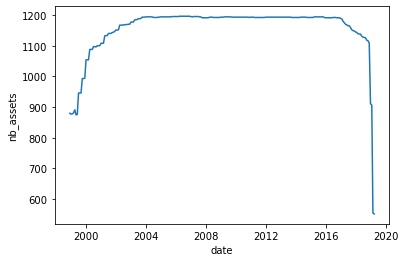

In [5]:
plt.plot(data_ml.date.unique(), data_ml.groupby('date').stock_id.count())
plt.xlabel("date")
plt.ylabel("nb_assets")
plt.show()

For simplicity, in the computation, investment universe will be shrinked to keep only the stocks for which I have the maximum number of points.

In [6]:
stock_ids = data_ml.stock_id.unique()
stock_days = data_ml.stock_id.value_counts().sort_index() 
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)] 
data_df = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]

In [7]:
data_df.head()

,date,stock_id,R1M_Usd
77549,1998-11-30,3,0.016
74656,1998-12-31,3,-0.028
74657,1999-01-31,3,0.004
74658,1999-02-28,3,-0.060
71769,1999-03-31,3,0.071


As I mentioned before, I apply momentum strategy on 1 month return. Momentum Investing involves going long financial assets showing upward-trending prices and short the respective assets with downward-trending prices. I will replicate the strategy of buying stocks with best return in past 15 months and selling stocks with worst return in the past 15 months. 

In [8]:
month_gap = 15
data_df['past_R'] =  data_df.R1M_Usd.shift(month_gap)
data_df.dropna(inplace=True)

Since some values of past_R shows infinite values due to 0 values of 1 monthly return, I drop those values

In [9]:
data_df.past_R = data_df.past_R.replace([np.inf, -np.inf], np.nan)
data_df.dropna(inplace = True)

Next, I move to divide stock based on momentum performance. As I mentioned, I will divide 10 groups

In [10]:
momentum_num = 10
data_df['group_rank']=data_df.groupby(['date'])['past_R'].transform(
                              lambda x: pd.qcut(x, momentum_num,labels=range(momentum_num)))
data_df.head()

,date,stock_id,R1M_Usd,past_R,group_rank
48737,2000-02-29,3,-0.024,0.016,5.0
51607,2000-03-31,3,0.018,-0.028,5.0
51608,2000-04-30,3,0.027,0.004,7.0
51609,2000-05-31,3,0.050,-0.060,3.0
45877,2000-06-30,3,0.008,0.071,5.0


Looking at return of equally weighted monthly return and mean of the monthly returns.

In [11]:
monthly_return = data_df.groupby(['date','group_rank'])['R1M_Usd'].mean()
monthly_weighted_return = monthly_return.groupby('group_rank').mean().sort_index()
monthly_weighted_return

group_rank
0.0    0.012701
1.0    0.011620
2.0    0.009842
3.0    0.013480
4.0    0.011631
5.0    0.011779
6.0    0.011258
7.0    0.012827
8.0    0.011947
9.0    0.019560
Name: R1M_Usd, dtype: float64

Considering the portfolio returns, we can see relatively monotonic increase mean returns from lowest bin to the highest bin. Implementing this strategy, the thing you should keep in mind that my analysis did not consider high transactions cost.(Also, some countries do not allow people to have short position in trading)